# Preprocessing of the dataset

In [1]:
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [2]:
# Load the dataset
df = pd.read_csv("world_bank_dataset.csv")
df 

,Country,Year,GDP (USD),Population,Life Expectancy,Unemployment Rate (%),CO2 Emissions (metric tons per capita),Access to Electricity (%)
0,Brazil,2010,1.493220e+12,8.290200e+08,66.7,3.81,10.79,76.76
1,Japan,2011,1.756270e+13,8.970100e+08,61.4,17.98,15.67,67.86
2,India,2012,1.642688e+13,6.698500e+08,69.1,16.02,2.08,81.08
3,Mexico,2013,1.189001e+13,1.138000e+08,80.1,6.26,19.13,53.46
4,India,2014,2.673020e+12,2.971000e+07,62.7,3.10,15.66,82.17
...,...,...,...,...,...,...,...,...
195,India,2015,1.110880e+12,6.727800e+08,78.5,22.30,11.36,66.04
196,Australia,2016,9.210290e+12,6.896500e+08,64.9,9.82,15.59,67.29
197,United States,2017,4.937150e+12,1.234820e+09,61.0,4.14,14.66,91.16
198,Canada,2018,1.088696e+13,2.625900e+08,76.5,2.28,7.25,59.21


In [3]:
# Dropping non-numeric columns
X = df.select_dtypes(include="number").drop(columns=["Year"]).copy()

X = X.loc[:, X.nunique(dropna=False) > 1]

preprocessor = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

X_preprocessed = preprocessor.fit_transform(X)
X_preprocessed


array([[-1.63999916,  0.20605122,  0.0383387 , -1.39405673,  0.12843493,
         0.26319505],
       [ 1.26387012,  0.36131615, -0.50279339,  0.69371695,  0.9849018 ,
        -0.34002028],
       [ 1.05861937, -0.15743633,  0.28337964,  0.40493527, -1.40021803,
         0.55599171],
       ...,
       [-1.01765652,  1.13275381, -0.54363355, -1.34543532,  0.80764124,
         1.2391839 ],
       [ 0.05751644, -1.08747304,  1.03892256, -1.61948324, -0.49285456,
        -0.92629136],
       [-1.09195787, -0.46431236,  0.75304146,  0.59205401,  1.16216236,
        -0.50132955]])

# Agglomerative Hierarchical Clustering (AHC)

In [4]:
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from mpl_toolkits.mplot3d import Axes3D

## Scatter plots before clustering

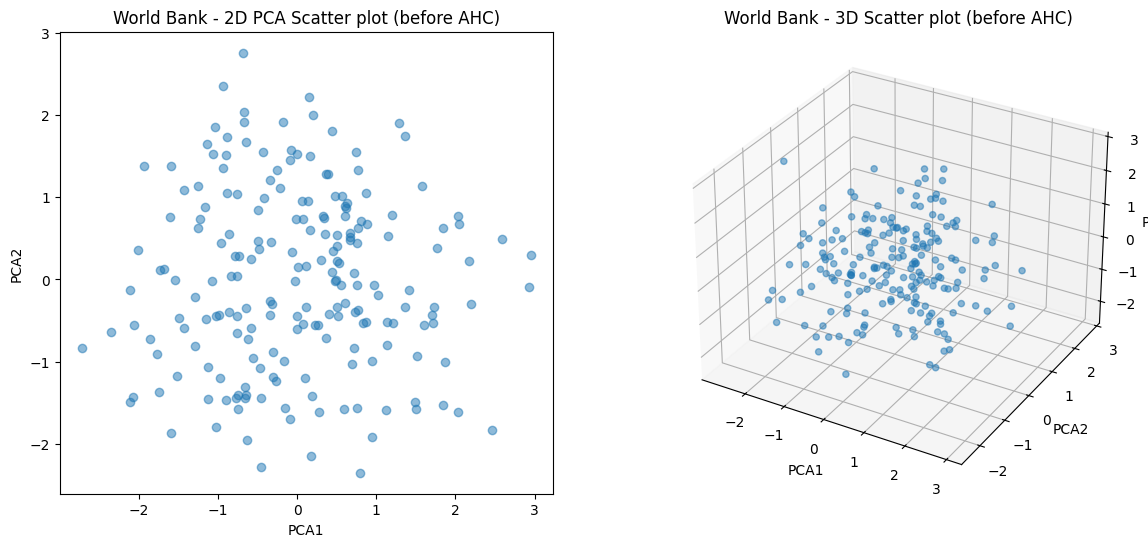

In [5]:
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X_preprocessed)

pca3 = PCA(n_components=3)
X_pca3 = pca3.fit_transform(X_preprocessed)

# 2D and 3D scatter plot before clustering
fig = plt.figure(figsize=(14, 6))

ax2 = fig.add_subplot(1, 2, 1)
ax2.scatter(
    X_pca2[:,0],
    X_pca2[:,1],
    alpha=0.5
)
ax2.set_xlabel("PCA1")
ax2.set_ylabel("PCA2")
ax2.set_title("World Bank - 2D PCA Scatter plot (before AHC)")

ax3 = fig.add_subplot(1, 2, 2, projection="3d")
ax3.scatter(
    X_pca3[:,0],
    X_pca3[:,1],
    X_pca3[:,2],
    alpha=0.5
)
ax3.set_xlabel("PCA1")
ax3.set_ylabel("PCA2")
ax3.set_zlabel("PCA3")
ax3.set_title("World Bank - 3D Scatter plot (before AHC)")
plt.show()

## Training

### Determining the optimal number of clusters
- Silhouette scores  
- Davies-Bouldin Index (DBI)  
- Calinski-Harabasz score (CHI)

In [6]:
candidate_clusters = range(2, 50)
sil_list_clusters = []
dbi_list_clusters = []
chi_list_clusters = []

for n in candidate_clusters:
    ahc_clusters = AgglomerativeClustering(n_clusters=n, linkage="ward")
    labels_clusters = ahc_clusters.fit_predict(X_preprocessed)

    sil_clusters = silhouette_score(X_preprocessed, labels_clusters)
    dbi_clusters = davies_bouldin_score(X_preprocessed, labels_clusters)
    chi_clusters = calinski_harabasz_score(X_preprocessed, labels_clusters)

    sil_list_clusters.append(sil_clusters)
    dbi_list_clusters.append(dbi_clusters)
    chi_list_clusters.append(chi_clusters)

    print(f"Number of clusters: {n}, Silhouette score: {sil_clusters:.3f}, Davies-Bouldin score: {dbi_clusters:.3f}, Calinski-Harabasz score: {chi_clusters:.3f}")

max_sil_clusters = max(sil_list_clusters)
min_dbi_clusters = min(dbi_list_clusters)
max_chi_clusters = max(chi_list_clusters)

optimal_clusters_sil = candidate_clusters[sil_list_clusters.index(max_sil_clusters)]
optimal_clusters_dbi = candidate_clusters[dbi_list_clusters.index(min_dbi_clusters)]
optimal_clusters_chi = candidate_clusters[chi_list_clusters.index(max_chi_clusters)]

print()
print(f"Highest Silhouette score: {max_sil_clusters:.3f}, Optimal number of clusters: {optimal_clusters_sil}")
print(f"Lowest Davies-Bouldin score: {min_dbi_clusters:.3f}, Optimal number of clusters: {optimal_clusters_dbi}")
print(f"Highest Calinski-Harbasz score: {max_chi_clusters:.3f}, Optimal number of clusters: {optimal_clusters_chi}")

Number of clusters: 2, Silhouette score: 0.107, Davies-Bouldin score: 2.581, Calinski-Harabasz score: 24.559
Number of clusters: 3, Silhouette score: 0.102, Davies-Bouldin score: 2.446, Calinski-Harabasz score: 23.595
Number of clusters: 4, Silhouette score: 0.101, Davies-Bouldin score: 2.015, Calinski-Harabasz score: 24.066
Number of clusters: 5, Silhouette score: 0.107, Davies-Bouldin score: 1.969, Calinski-Harabasz score: 23.267
Number of clusters: 6, Silhouette score: 0.120, Davies-Bouldin score: 1.826, Calinski-Harabasz score: 23.240
Number of clusters: 7, Silhouette score: 0.120, Davies-Bouldin score: 1.754, Calinski-Harabasz score: 22.749
Number of clusters: 8, Silhouette score: 0.126, Davies-Bouldin score: 1.729, Calinski-Harabasz score: 22.427
Number of clusters: 9, Silhouette score: 0.135, Davies-Bouldin score: 1.632, Calinski-Harabasz score: 22.420
Number of clusters: 10, Silhouette score: 0.148, Davies-Bouldin score: 1.538, Calinski-Harabasz score: 22.595
Number of clusters

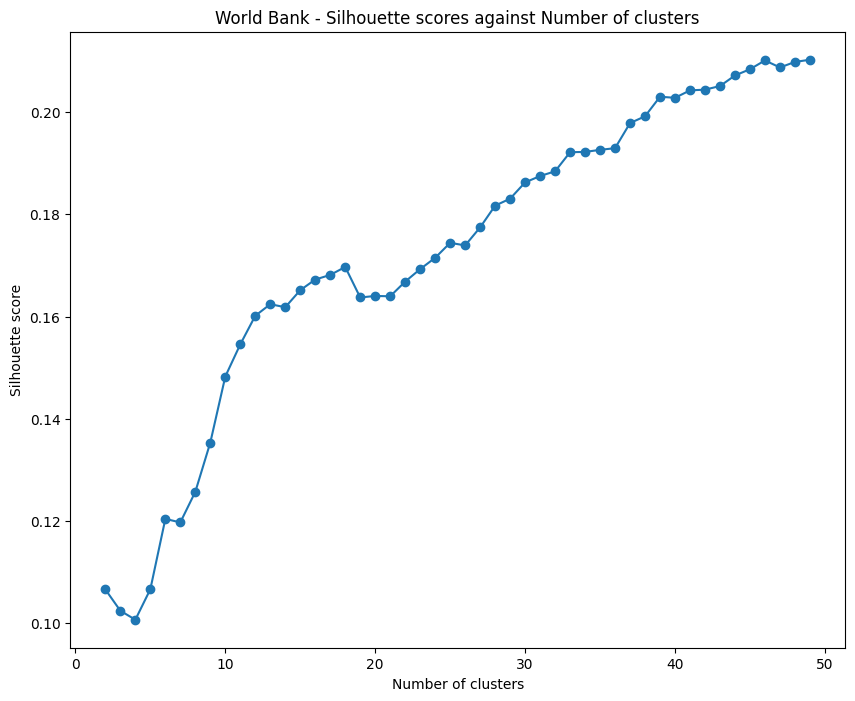

In [7]:
plt.figure(figsize=(10, 8))
plt.plot(candidate_clusters, sil_list_clusters, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.title("World Bank - Silhouette scores against Number of clusters")
plt.show()

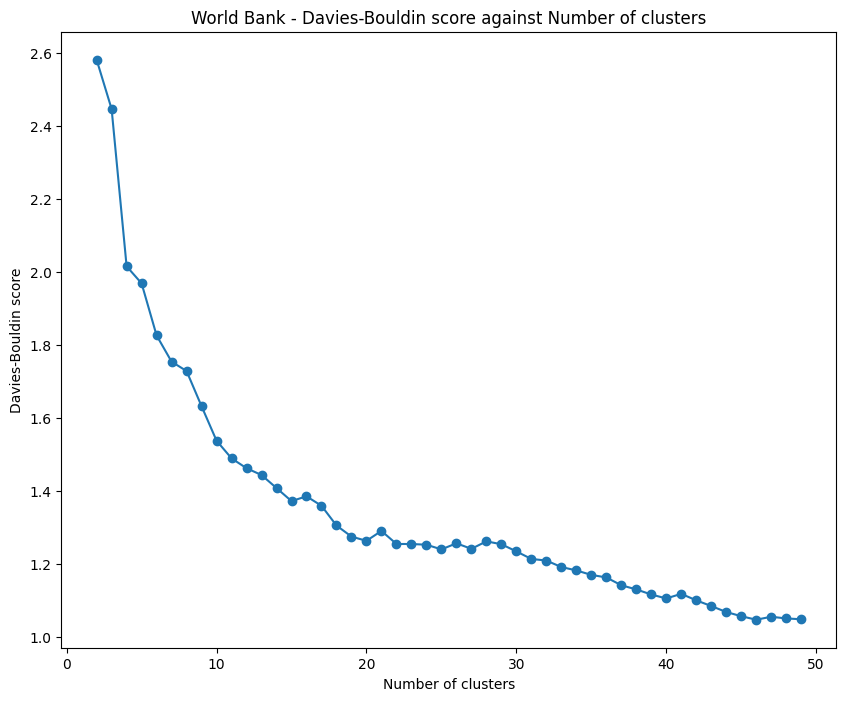

In [8]:
plt.figure(figsize=(10, 8))
plt.plot(candidate_clusters, dbi_list_clusters, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Davies-Bouldin score")
plt.title("World Bank - Davies-Bouldin score against Number of clusters")
plt.show()

Text(0.5, 1.0, 'World Bank - Calinski-Harabasz score against Number of clusters')

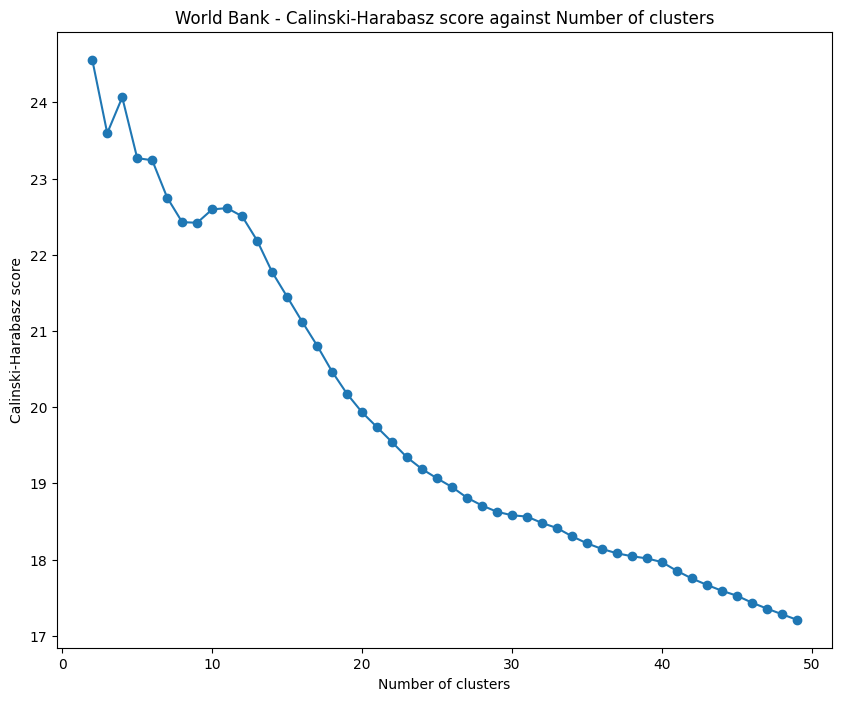

In [9]:
plt.figure(figsize=(10, 8))
plt.plot(candidate_clusters, chi_list_clusters, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Calinski-Harabasz score")
plt.title("World Bank - Calinski-Harabasz score against Number of clusters")

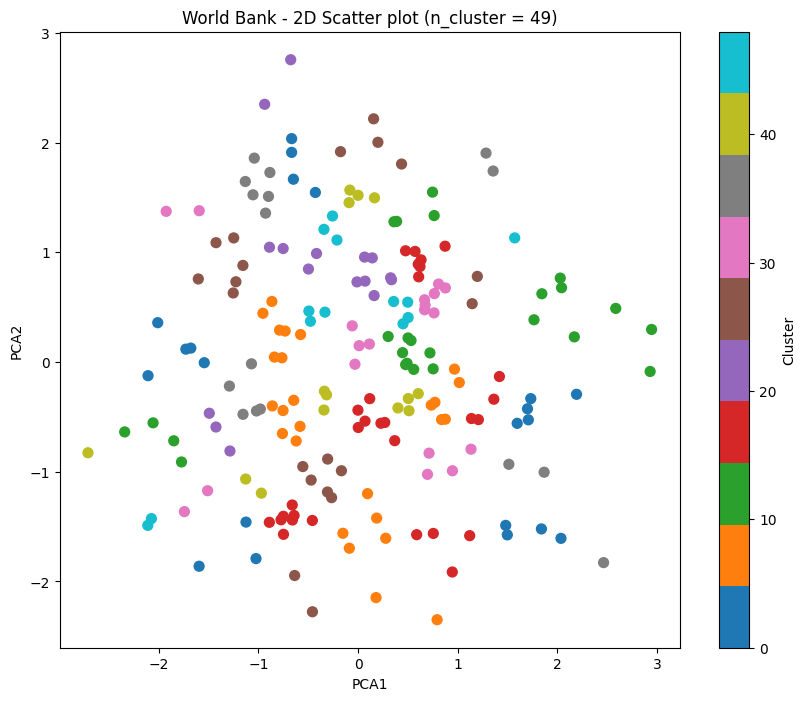

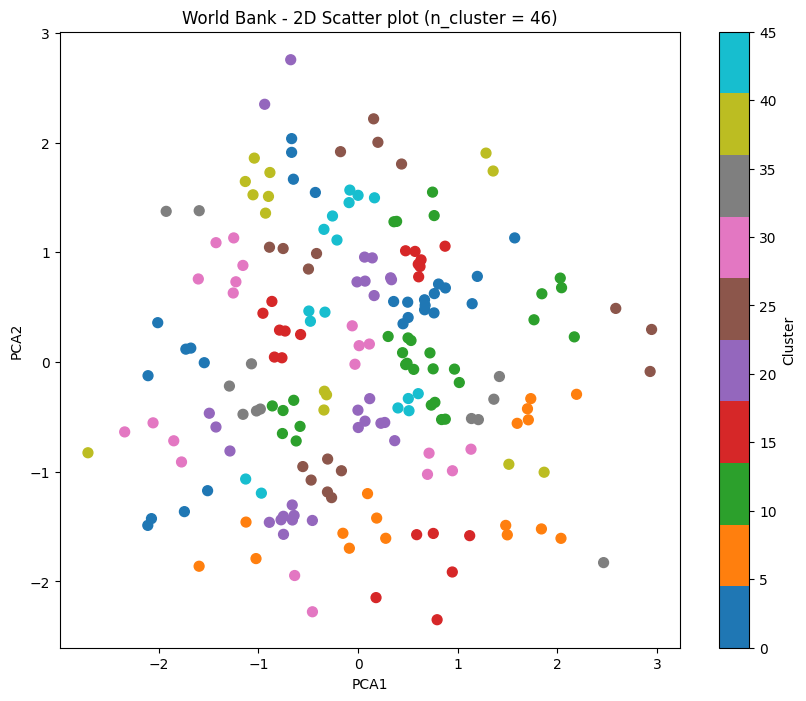

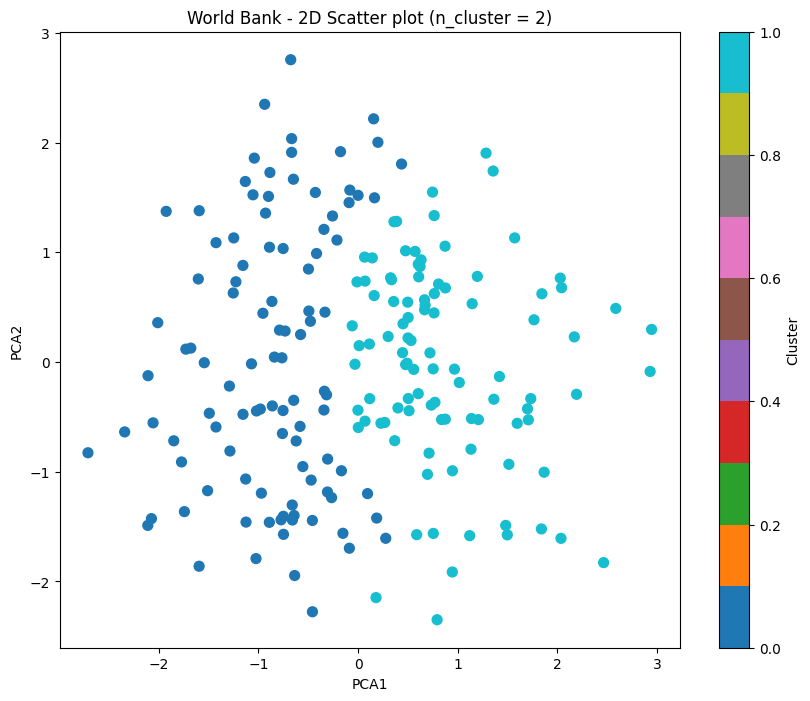

In [10]:
# Determining ultimate optimal number of clusters using by plotting 2D PCA scatter plots
optimal_clusters_options = [49, 46, 2] # Change according to the results above

for c in optimal_clusters_options:
    ahc_optimal_c = AgglomerativeClustering(n_clusters=c, linkage="ward")
    labels_optimal_c = ahc_optimal_c.fit_predict(X_pca2)

    plt.figure(figsize=(10, 8))
    plt.scatter(
        X_pca2[:,0],
        X_pca2[:,1],
        c=labels_optimal_c,
        cmap="tab10",
        s=50
    )
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.title(f"World Bank - 2D Scatter plot (n_cluster = {c})")
    plt.colorbar(label="Cluster")
    plt.show()


    # # Dendrogram 
    # Z_clusters = linkage(X_pca2, method="ward")
    # dendrogram(Z_clusters)
    # plt.xlabel("Data points")
    # plt.ylabel("Distance")
    # plt.title(f"World Bank - Dendrogram (n_cluster = {c})")
    # plt.show()


## Experimental analysis

### Analysis of AHC model performance on different linkage criterias
(using optimal number of clusters)
- ward, single, complete, average

Linkage method: Ward


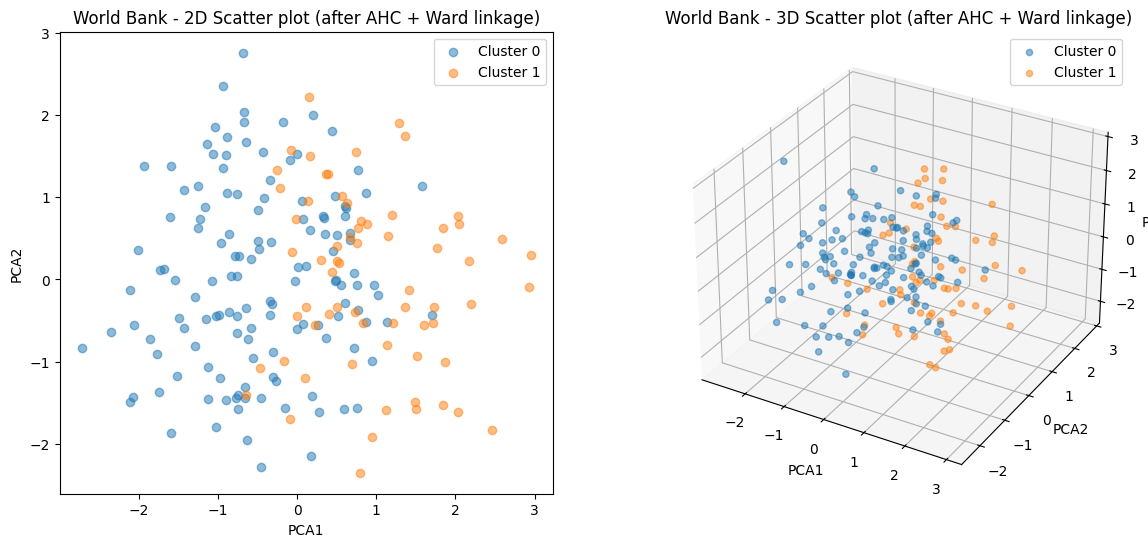

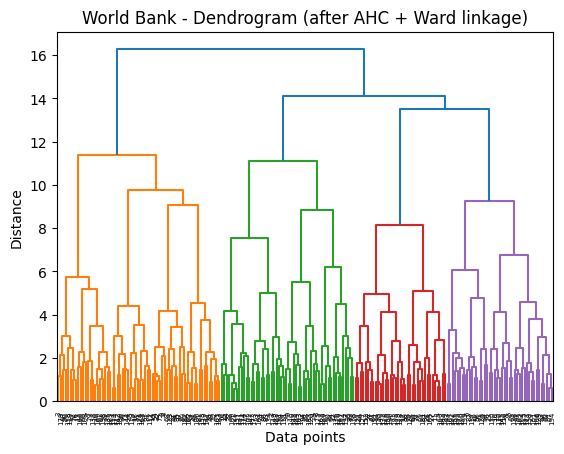

----------------------------------------------------------------------------------------------
Linkage method: Single


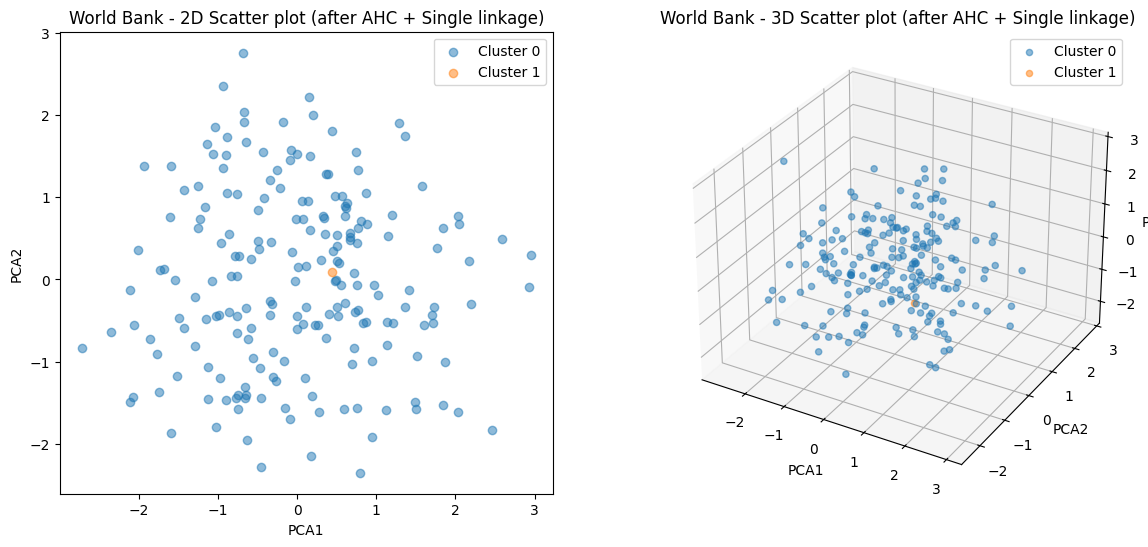

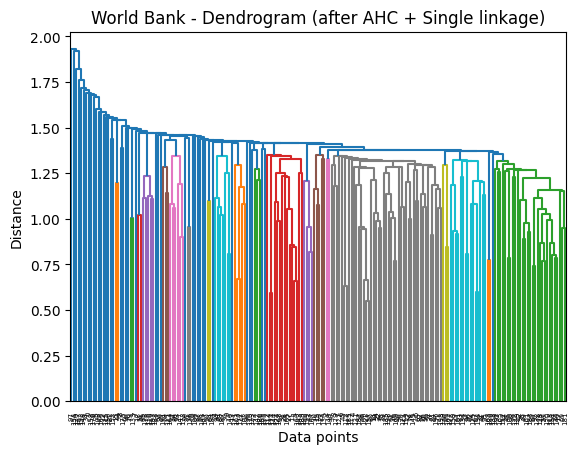

----------------------------------------------------------------------------------------------
Linkage method: Complete


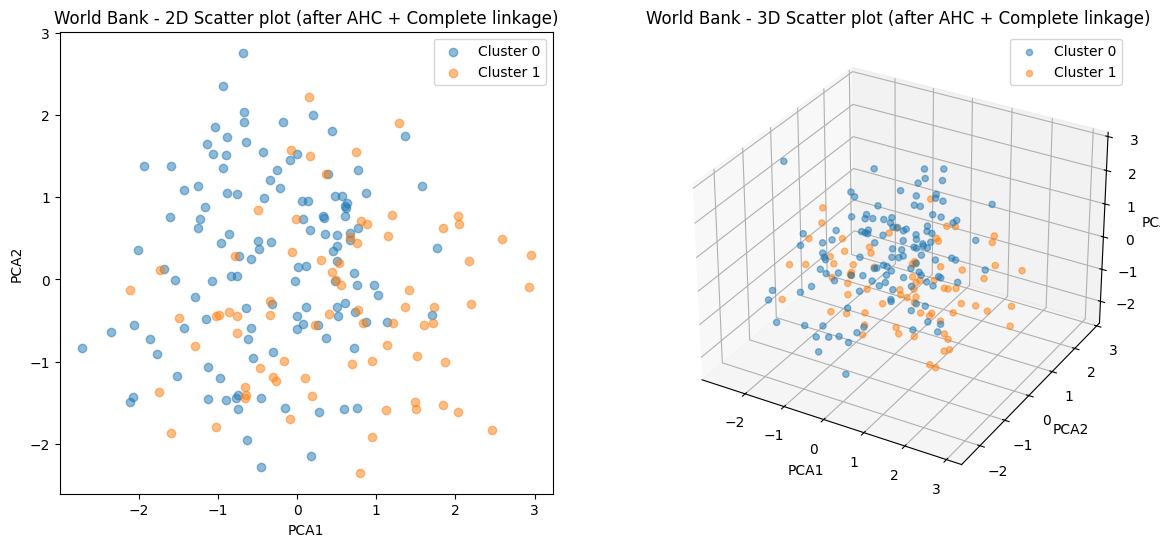

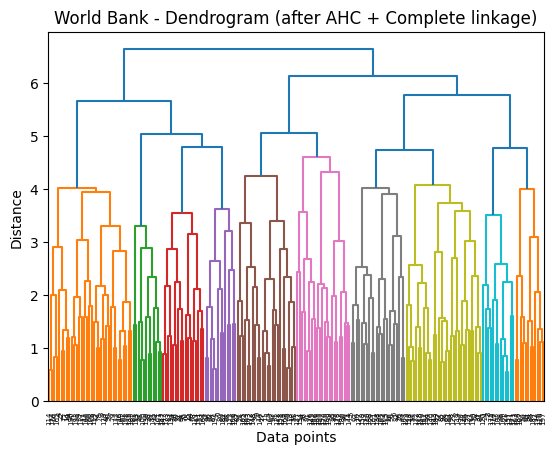

----------------------------------------------------------------------------------------------
Linkage method: Average


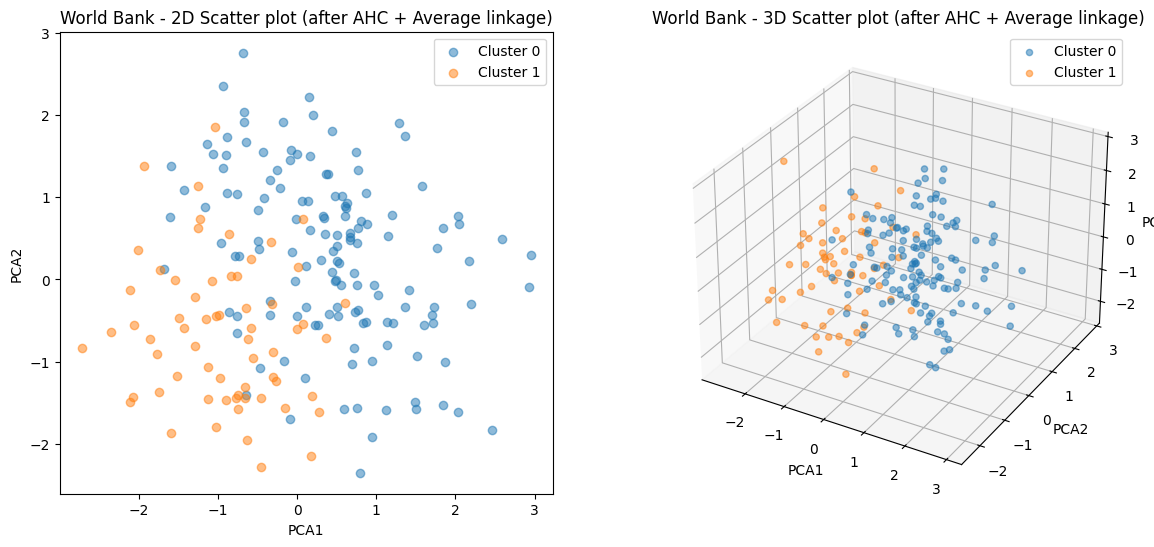

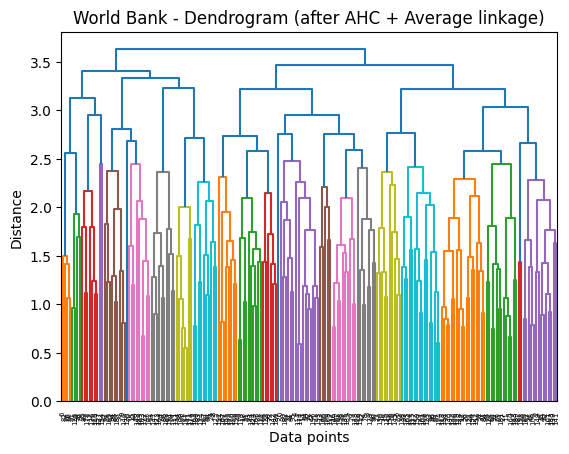

----------------------------------------------------------------------------------------------

Linkage method | Silhouette score | Davis-Bouldin score | Calinski-Harabasz score
ward         | 0.107 | 2.581 | 24.559
single       | 0.132 | 0.739 | 1.750
complete     | 0.086 | 3.011 | 19.486
average      | 0.125 | 2.487 | 26.449


In [11]:
optimal_clusters = 2 # Change based on results above
linkage_methods = ["ward", "single", "complete", "average"]
sil_list_linkage = []
dbi_list_linkage = []
chi_list_linkage = []

for m in linkage_methods:
    print(f"Linkage method: {m.capitalize()}")

    # Conduct AHC
    ahc_linkage = AgglomerativeClustering(n_clusters=optimal_clusters, linkage=m)
    labels_linkage = ahc_linkage.fit_predict(X_preprocessed)

    # Plot 2D PCA scatter plot
    fig_linkage = plt.figure(figsize=(14, 6))
    ax2_linkage = fig_linkage.add_subplot(1, 2, 1)
    
    for c in np.unique(labels_linkage):
        ax2_linkage.scatter(
            X_pca2[labels_linkage == c, 0],
            X_pca2[labels_linkage == c, 1],
            label=f"Cluster {c}",
            alpha=0.5,
        )
    
    ax2_linkage.set_xlabel("PCA1")
    ax2_linkage.set_ylabel("PCA2")
    ax2_linkage.set_title(f"World Bank - 2D Scatter plot (after AHC + {m.capitalize()} linkage)")
    ax2_linkage.legend()

    # Plot 3D PCA scatter plot
    ax3_linkage = fig_linkage.add_subplot(1, 2, 2, projection="3d")

    for c in np.unique(labels_linkage):
        ax3_linkage.scatter(
            X_pca3[labels_linkage == c, 0],
            X_pca3[labels_linkage == c, 1],
            X_pca3[labels_linkage == c, 2],
            label=f"Cluster {c}",
            alpha=0.5
        )
    
    ax3_linkage.set_xlabel("PCA1")
    ax3_linkage.set_ylabel("PCA2")
    ax3_linkage.set_zlabel("PCA3")
    ax3_linkage.set_title(f"World Bank - 3D Scatter plot (after AHC + {m.capitalize()} linkage)")
    ax3_linkage.legend()

    plt.show()

    # Plot dendrogram
    Z_linkage = linkage(X_preprocessed, method=m)
    dendrogram(Z_linkage)
    plt.xlabel("Data points")
    plt.ylabel("Distance")
    plt.title(f"World Bank - Dendrogram (after AHC + {m.capitalize()} linkage)")
    plt.show()
    print("----------------------------------------------------------------------------------------------")

    # Silhouette score, DBI score, CHI score
    sil_linkage = silhouette_score(X_preprocessed, labels_linkage)
    dbi_linkage = davies_bouldin_score(X_preprocessed, labels_linkage)
    chi_linkage = calinski_harabasz_score(X_preprocessed, labels_linkage)

    sil_list_linkage.append(sil_linkage)
    dbi_list_linkage.append(dbi_linkage)
    chi_list_linkage.append(chi_linkage)

print()
print("Linkage method | Silhouette score | Davis-Bouldin score | Calinski-Harabasz score")
for i, m in enumerate(linkage_methods):
    print(f"{m:<12} | {sil_list_linkage[i]:.3f} | {dbi_list_linkage[i]:.3f} | {chi_list_linkage[i]:.3f}")
# Should still rely on dendrogram and PCA scatter plots to determine best linkage method as dendrogram visualizes the full hierarchical process

### Analysis of AHC model performance on different number of principle components
(using optimal number of clusters and ward linkage)

In [12]:
n_features = X_preprocessed.shape[1] # Number of feature columns in dataset
pca_comps = list(range(2, n_features+1))

sil_pca_list = []
dbi_pca_list = []
chi_pca_list = []

for n in pca_comps:
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X_preprocessed)

    # AHC 
    ahc_pca = AgglomerativeClustering(n_clusters=optimal_clusters, linkage="ward")
    labels_pca = ahc_pca.fit_predict(X_pca)

    # Scores
    sil_pca = silhouette_score(X_pca, labels_pca)
    dbi_pca = davies_bouldin_score(X_pca, labels_pca)
    chi_pca = calinski_harabasz_score(X_pca, labels_pca)

    sil_pca_list.append(sil_pca)
    dbi_pca_list.append(dbi_pca)
    chi_pca_list.append(chi_pca)

# Results
print(f"Number of components | Silhouette score | Davies-Bouldin score | Calinski-Harabasz score")
for i, n in enumerate(pca_comps):
    print(f"{n:<21} | {sil_pca_list[i]:.3f} | {dbi_pca_list[i]:.3f} | {chi_pca_list[i]:.3f}")

best_sil_pca = max(sil_pca_list)
best_dbi_pca = min(dbi_pca_list)
best_chi_pca = max(chi_pca_list)

n_pc_sil = pca_comps[sil_pca_list.index(best_sil_pca)]
n_pc_dbi = pca_comps[dbi_pca_list.index(best_dbi_pca)]
n_pc_chi = pca_comps[chi_pca_list.index(best_chi_pca)]

print()
print(f"Highest Silhouette score: {best_sil_pca:.3f}, Optimal number of components: {n_pc_sil}")
print(f"Lowest Davies-Bouldin score: {best_dbi_pca:.3f}, Optimal number of components: {n_pc_dbi}")
print(f"Highest Calinski-Harabasz score: {best_chi_pca:.3f}, Optimal number of components: {n_pc_chi}")

Number of components | Silhouette score | Davies-Bouldin score | Calinski-Harabasz score
2                     | 0.314 | 1.285 | 95.473
3                     | 0.219 | 1.618 | 58.688
4                     | 0.162 | 2.013 | 37.420
5                     | 0.123 | 2.576 | 27.549
6                     | 0.107 | 2.581 | 24.559

Highest Silhouette score: 0.314, Optimal number of components: 2
Lowest Davies-Bouldin score: 1.285, Optimal number of components: 2
Highest Calinski-Harabasz score: 95.473, Optimal number of components: 2


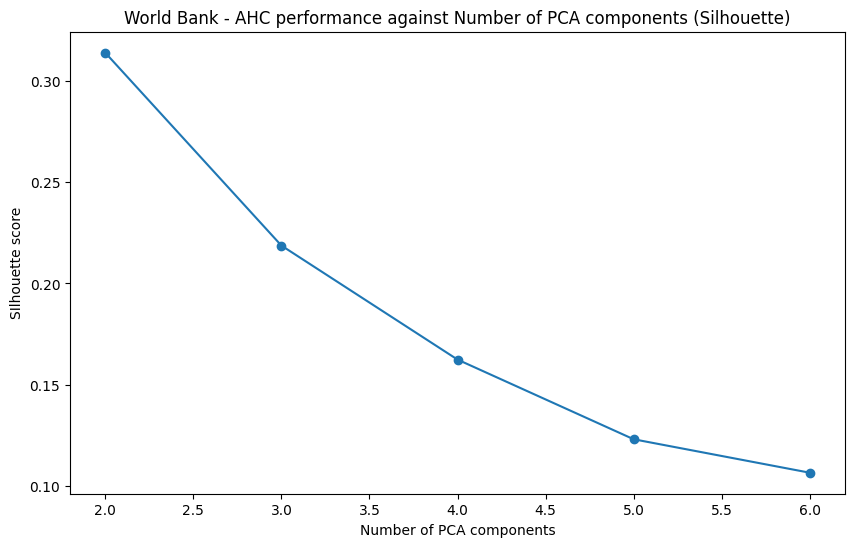

In [13]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(pca_comps, sil_pca_list, marker="o")
plt.xlabel("Number of PCA components")
plt.ylabel("SIlhouette score")
plt.title("World Bank - AHC performance against Number of PCA components (Silhouette)")
plt.show()

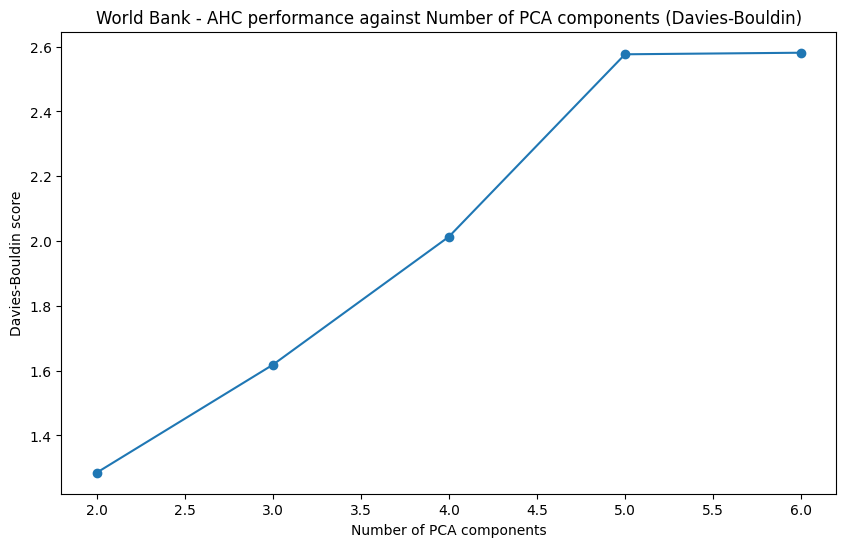

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(pca_comps, dbi_pca_list, marker="o")
plt.xlabel("Number of PCA components")
plt.ylabel("Davies-Bouldin score")
plt.title("World Bank - AHC performance against Number of PCA components (Davies-Bouldin)")
plt.show()

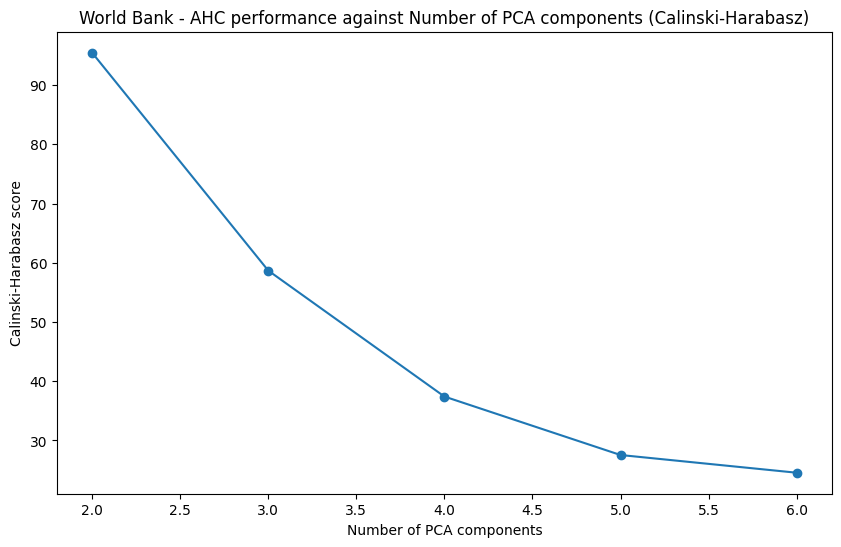

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(pca_comps, chi_pca_list, marker="o")
plt.xlabel("Number of PCA components")
plt.ylabel("Calinski-Harabasz score")
plt.title("World Bank - AHC performance against Number of PCA components (Calinski-Harabasz)")
plt.show()

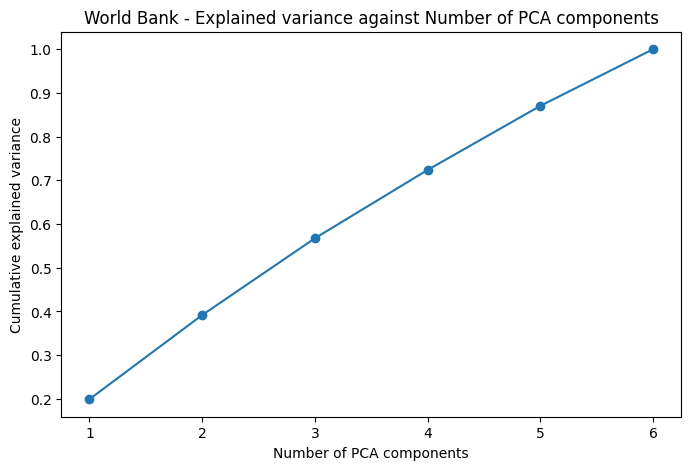

In [22]:
# Plotting variance against number of PCA components
pca_full = PCA().fit(X_preprocessed)
explained_var = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_var)+1), explained_var, marker="o")
plt.xlabel("Number of PCA components")
plt.ylabel("Cumulative explained variance")
plt.title("World Bank - Explained variance against Number of PCA components")
plt.show()

## Final AHC on the optimal confguration
- number of clusters  
- number of principle components  
- linkage criteria  

In [16]:
pca_final = PCA(n_components=2) # change according to the results from the previous code cell
X_pca_final = pca_final.fit_transform(X_preprocessed)

ahc_final = AgglomerativeClustering(n_clusters=optimal_clusters, linkage="ward")
labels_final = ahc_final.fit_predict(X_pca_final)

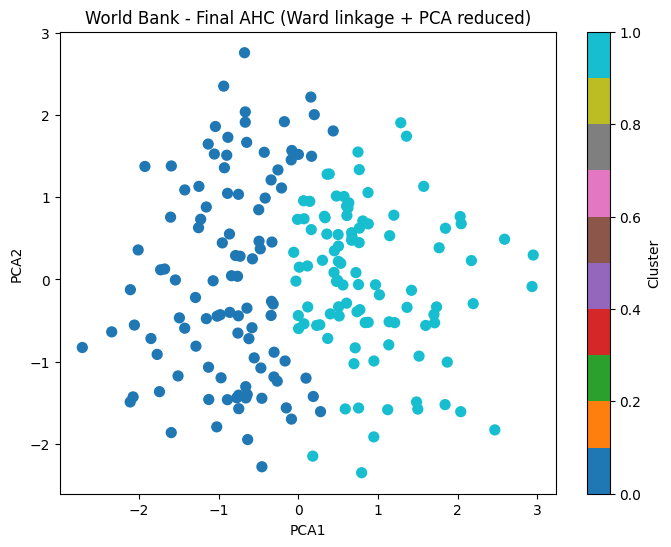

In [17]:
# Plot final 2D scatter plot
plt.figure(figsize=(8, 6))

plt.scatter(
        X_pca_final[:,0],
        X_pca_final[:,1], 
        c=labels_final, 
        cmap="tab10", 
        s=50
    )

plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("World Bank - Final AHC (Ward linkage + PCA reduced)")
plt.colorbar(label="Cluster")

plt.show()

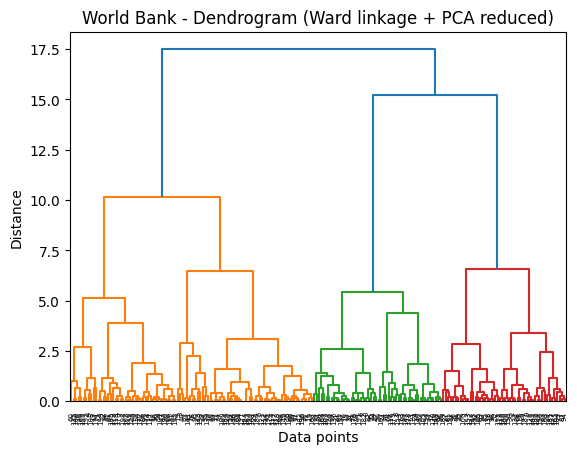

In [23]:
# Plot dendrogram
Z_linkage = linkage(X_pca_final, method="ward")
dendrogram(Z_linkage)
plt.xlabel("Data points")
plt.ylabel("Distance")
plt.title(f"World Bank - Dendrogram (Ward linkage + PCA reduced)")
plt.show()

### Cluster analysis

In [19]:
# Cluster analysis
X["Cluster"] = labels_final # Add cluster labels to df
cluster_summary = X.groupby("Cluster").mean().round(2)
print(cluster_summary)

            GDP (USD)    Population  Life Expectancy  Unemployment Rate (%)  \
Cluster                                                                       
0        1.040696e+13  9.689004e+08            61.99                  14.06   
1        1.073699e+13  4.992891e+08            70.84                  12.45   

         CO2 Emissions (metric tons per capita)  Access to Electricity (%)  
Cluster                                                                     
0                                          8.30                      78.68  
1                                         11.89                      66.84  


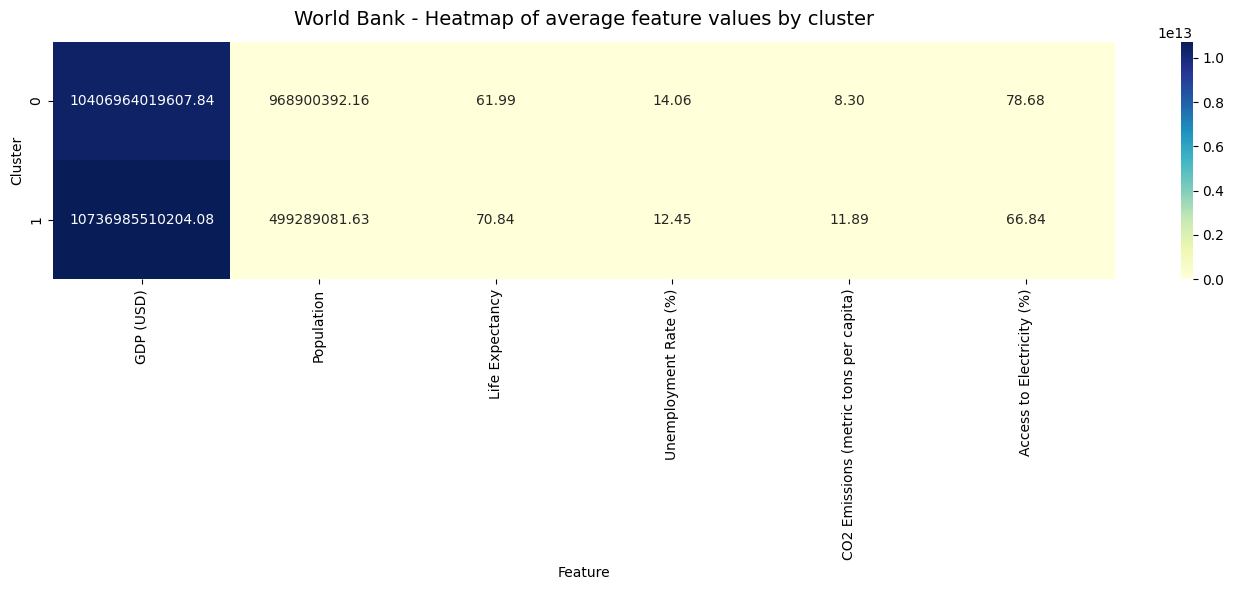

In [21]:
# Heatmap for cluster analysis
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.heatmap(cluster_summary, annot=True, cmap="YlGnBu", fmt=".2f", cbar=True)
plt.title("World Bank - Heatmap of average feature values by cluster", fontsize=14, pad=12)
plt.xlabel("Feature")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()